# Random Forest Model Development

This notebook goes through model development for a Random Forest (RF) regressor designed for high-resolution nutrient prediction in the Southern Ocean. 

*Objectives:*

- Train RFR on data from BGC-Argo ocean autonomous profilers and GO-SHIP bottle data
- Validate RFR to select the best model parameters, use cross-validation to assess overfitting
- Test RFR for an estimate of prediction error, and compare to neural network methods
- Predict missing variable (here, nitrate) on new input data from rapidly-sampling Seagliders

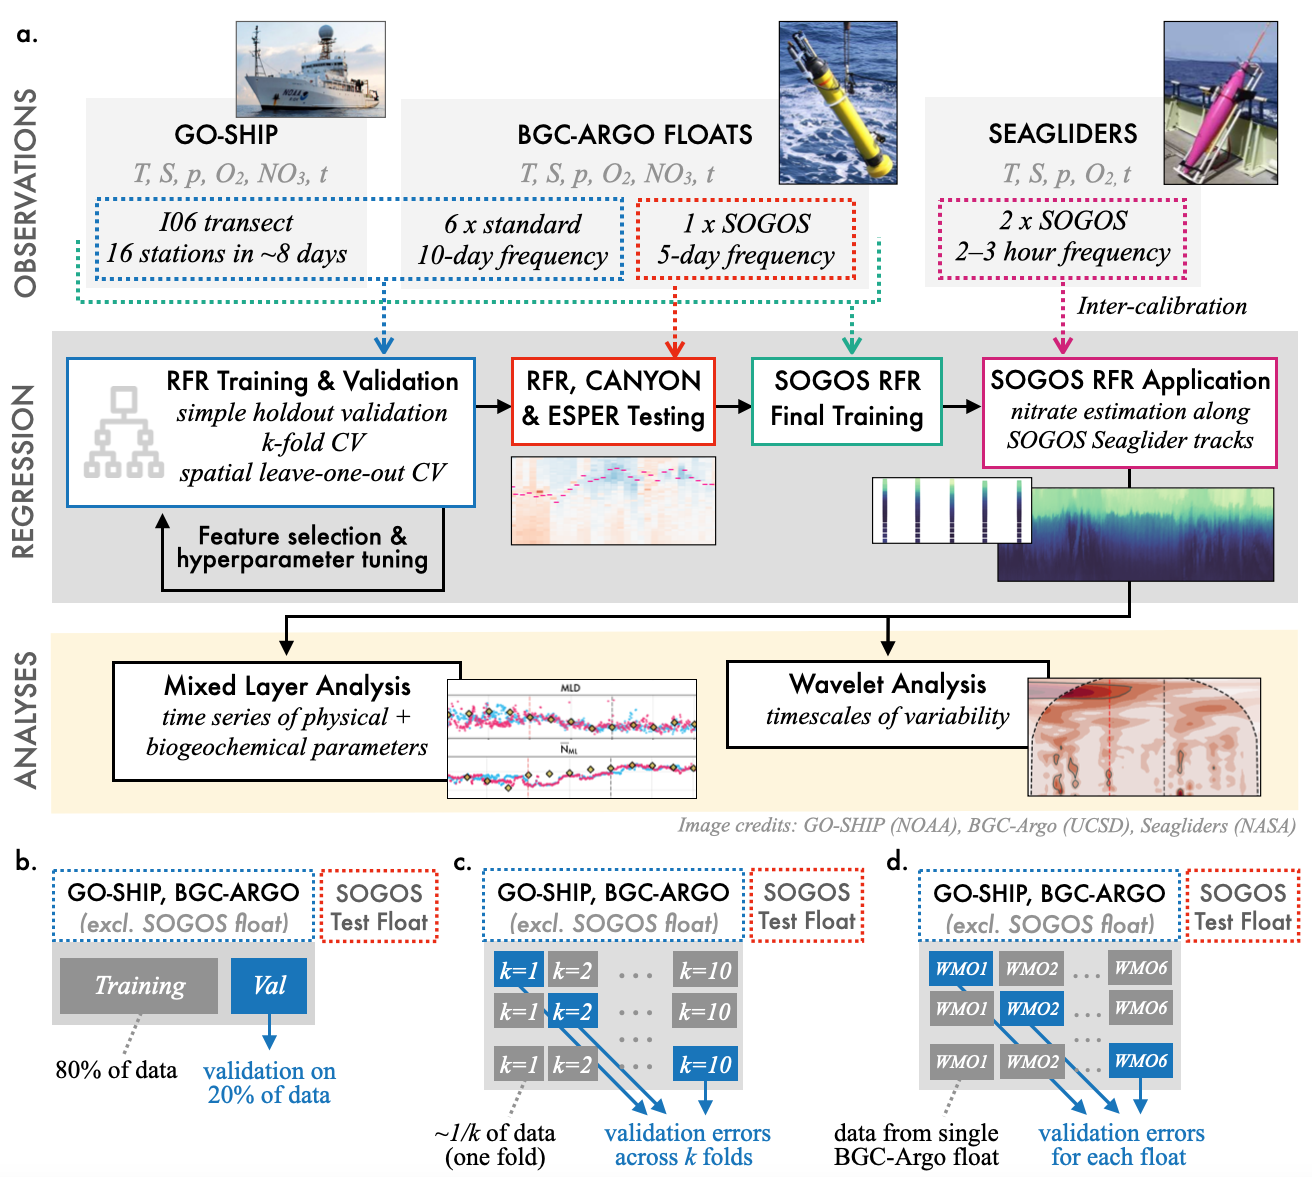

In [1]:
from IPython.display import Image
Image(filename='../images/methods_schematic.png') 

# Introduction: Random Forest Regression

Random Forest (RF) regression is a supervised machine learning method that averages the results over a "forest" of $n$ decision trees for final prediction. Each decision tree determines a series of conditions at each node based on a set of observed variables, referred to as features. For regression, the trees find conditions that best separate the target observations into branches with the least variance. 

Formally, observations are sorted into $j$ regions of predictor space ($R_j$) during training. Following the notation in James et al. (2013), each node in the tree considers a split into two new regions based on a condition $s$ for a predictor $X_j$:
\begin{equation}
\begin{split}
R_1(j,s) = \{X|X_j < s\} \text{ and } R_2(j,s) = \{X|X_j \ge s\}, \\
\end{split}
\end{equation}
and each region is assigned a prediction value that is the average of all target variable values ($\hat{y}_{R_j}$ ) within $R_j$. The condition $s$ is chosen to minimize the residual sum of squares in the resulting bins:
\begin{equation}
\begin{split}
\sum_{i: \: x_i \in \: R_1(j,s)}{} (y_i-\hat{y}_{R_1})^2 \; + \sum_{i: \: x_i \in \: R_2(j,s)}{} (y_i-\hat{y}_{R_2})^2,
\end{split}
\end{equation}
where $y_i$ represents each observed value. During testing, validation, and prediction, RF sorts input observations into the regions and assigns them the value $\hat{y}_{R_j}$. One advantage of RF is that it limits the decision at each node split to a random subset of features. As a result, the trees in Random Forest are less correlated than those in a family of ``bagged'' trees which consider all possible features at all nodes. The RF method is therefore less prone to overfitting, especially on spatiotemporally biased data (Stock et.al (2022), Sharp et al. 2022). 

# PART 0: Import Packages and Plotting Parameters

In [3]:
# Data Structure/Organization Packages
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma
import importlib

# Machine Learning/Statistics Packages
import scipy
from scipy.stats import kde
from scipy.stats import iqr

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

# Plotting Packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import matplotlib.colors as mpcolors
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patheffects as pe
import seaborn as sns
from labellines import labelLine, labelLines
import warnings

# Utility Packages
import random as rand
# import os
# import math
# import itertools
# from scipy import interpolate
from tqdm import tqdm
from importlib import reload

# Oceanography Packages
import gsw
from cmocean import cm as cmo
# import geopy.distance

In [4]:
# Modules
import mod_main as sg
import mod_L3proc as gproc     # for L3 grid processing
import mod_DFproc as dfproc    # for dataframe processing
import mod_plot as sgplot 
import mod_RFR as rfr

# Download data
# from mod_main import floatDF, shipDF # input data
from mod_main import sgfloat, dav_float # sogos float (yd<205)
from mod_main import dav_6030 # long mld series for 5906030

from mod_main import sg659, sg660 
from mod_main import dav_659, dav_660
from mod_main import df_659, df_660 # output of this notebook

from mod_RFR import var_list, model_list
from mod_RFR import mltraining, mlvalidation, mltest
from mod_RFR import RF_test, RF_validation

In [5]:
plt.rcParams.update(sgplot.my_params(14))

# PART 1: Data Selection: Ocean Autonomous Profilers

## 1.0 Study Region

Here, we develop a regional model using SOGOS observations, GO-SHIP I06 bottle data and observations from six BGC-Argo floats (WMO: 5904469, 5904659, 5905368, 5905996, 5906031, 5906207), which provided coverage of the Antarctic Southern Zone (ASZ) bounded by the Polar Front and Sea Ice Edge.  

The Seagliders sampled for 86 days, from May 1, 2019 to July 25, 2019, covering a region spanning approximately 30-40 E and 50-54 S as shown below. SG659 and SG660 completed 456 and 502 V-shaped dives, respectively, to approximately ~1000 m and sampled during both the descent and ascent. The gliders generally surfaced every 4-6 hours (profiles every 2-3 hours), while the BGC-Argo float sampled with a 5-day profiling frequency. The SOGOS float returned 16 profiles within the duration of the Seaglider mission. After being deployed along the 30E I06 cruise track around -51.5S, the three profilers were advected eastward by the Antarctic Circumpolar Current (ACC). The platforms pass through a standing meander region by the Southwest Indian Ridge (SWIR), which is a known hotspot of enhanced eddy kinetic energy (EKE) (balwada2024_Tracer, yung2022_Topographic). Further details on the deployment and the profilers' path from a high to low EKE region can be found in Dove et. al. (2021). 


### Figure: Study Region

(a) Trajectories for Seagliders SG659 and SG660 are shown in blue and magenta, respectively. 
Yellow diamonds denote locations of the float profiles. 

(b) Expanded view of the float (yellow) and glider SG660 (magenta) as they traverse from the high EKE region (yeardays<150) to the low EKE region (yeardays<170). 
Magenta text indicates yearday of the subset of observations highlighted in purple. Background colored by EKE [m^2/s^2] averaged over the deployment period.

Text(0.5, 1.0, 'SOGOS Study Region')

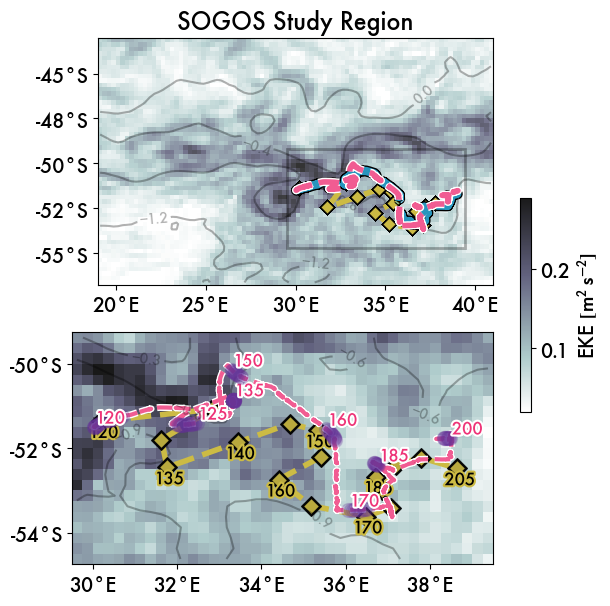

In [6]:
reload(sgplot)
ax = sgplot.study_region_eke(fs=(6,6), fontsize=12)
ax.set_title('SOGOS Study Region')

## 1.1 Identify Training Floats

Observations are first separated into training, validation, and test datasets during development. Our regional model is developed using GO-SHIP I06 bottle data and observations from six BGC-Argo floats (WMO: 5904469, 5904659, 5905368, 5905996, 5906031, 5906207; Figure \ref{fig:argo_map}), which provided coverage of the Antarctic Southern Zone (ASZ) bounded by the Polar Front and Sea Ice Edge. The combined GO-SHIP and BGC-Argo dataset is split 80\% and 20\% into the training and validation datasets, respectively (Figure \ref{fig:workflow}, \ref{fig:argo_map}). Typical machine learning workflows normally construct test datasets by random subsampling. However, our goal for testing in this particular use case is to get a final independent estimate of model error when applied onto the Seaglider tracks. Since the Seagliders sample close to the SOGOS float by experimental design, the entirety of the SOGOS float data (WMO 5906030) is reserved for testing. We emphasize that RF applications in the geosciences should consider the specific goal of the regressor when determining what data constitutes the training and test datasets. 

- Note that the DataFrame `sgfloat` contains observations from the SOGOS float WMO 5906030. 

In [9]:
# Import ship and float data for training
reload(sg)
from mod_main import floatDF, shipDF # input data
from mod_plot import wmo_colors

wmoids = pd.unique(floatDF['wmoid'])

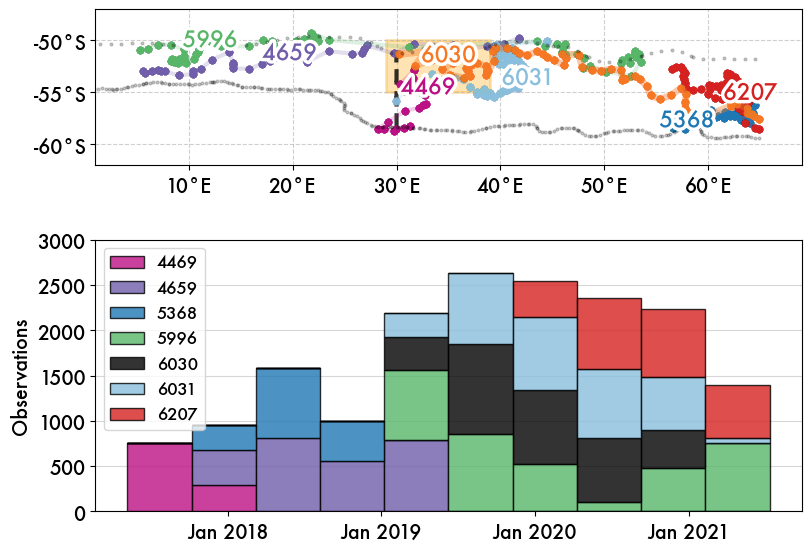

In [173]:
# Visualize float data
reload(sgplot)
warnings.filterwarnings("ignore")

reload(sgplot)
fig, axs = plt.subplots(2,1, figsize=(8,6), constrained_layout='True')
sgplot.training_float_map(floatDF, ax = axs[0]);
sgplot.argo_time_coverage(floatDF, fontsize=12, ax=axs[1]);


# PART 2: Preparing ML Data for Training, Validation, Testing

- Prepare data for RF development by subsampling and scaling. 



For BGC-Argo and GO-SHIP data, only observations up to depths of 1000 m are used to match the vertical range of the gliders. Random subsets with ~80% and ~20% of this data are used for training and simple holdout validation, respectively. When data are split into these subsets, observations from each profile are always kept together rather than sampling point observations individually. With this subsampling approach, each RF regressor is trained or validated on data containing complete vertical profiles, such that information about the local vertical structure is preserved. The training dataset consists of 11645 observations, and the validation dataset has 2933 observations. The test dataset from the withheld SOGOS float (WMO:5906030) has 3308 observations, from 16 profiles. All features are standardized to have unit variance and zero mean before training. The parameters of the standard scaler are determined from the training data and applied to the validation and testing data.

In [21]:
# Add seasonal variable
def add_yd_sinusoids(DF):
    DF['ydcos'] = [sg.get_ydsines(x)[0] for x in DF.yearday.values]
    DF['ydsin'] = [sg.get_ydsines(x)[1] for x in DF.yearday.values]
    return DF
floatDF = add_yd_sinusoids(floatDF)
shipDF = add_yd_sinusoids(shipDF)

# Choose final features to be tested
tvars = ['yearday','lat','lon','pressure','CT', 'SA','oxygen', 'sigma0', 'log_buoyancy', 
         'spice','o2sat', 'ydcos', 'ydsin']
pvars = ['nitrate']  # prediction variable

# Take variables of interest
floatDF = floatDF[tvars + pvars + ['wmoid', 'profid', 'dist_maxb']].dropna()
shipDF = shipDF[tvars + pvars + ['profid', 'dist_maxb']].dropna() # dont drop on wmoid yet

print('# Ship observations (without NaNs): \t', shipDF.shape[0])
print('# Float observations (without NaNs ): \t', floatDF.shape[0])
print('# 5906030 observations (without NaNs): \t', floatDF[floatDF.wmoid==5906030].shape[0])

# Ship observations (without NaNs): 	 242
# Float observations (without NaNs ): 	 17644
# 5906030 observations (without NaNs): 	 3308


## 2.1 Subsample data into training, validation, and test sets

In [158]:
# Split float and ship profiles separately (method in mod_RFR.py)
# Note that observations from vertical profiles are always kept together.
[training_float, validation_float, empty] = rfr.split_profiles(floatDF[floatDF.wmoid!=5906030], test_split = False)
[training_ship, validation_ship, empty] = rfr.split_ship(shipDF, test_split = False)

training = pd.concat([training_float, training_ship], ignore_index=True)
validation = pd.concat([validation_float, validation_ship], ignore_index=True)
test = floatDF[floatDF.wmoid==5906030] # set SOGOS 

print('Subsampled Datasets: ')
# print('wmoids: ' + str(wmoids))
print('# training observations: \t' + str(len(training)))
print('# validation observations: \t' + str(len(validation)))
print('# test observations: \t\t' + str(len(test)))

Subsampled Datasets: 
# training observations: 	11645
# validation observations: 	2933
# test observations: 		3308


In [160]:
# dir = '../working-vars/RF-training/'
# training.to_csv(dir + 'mldata_training.csv')
# validation.to_csv(dir + 'mldata_validation.csv')
# test.to_csv(dir + 'mldata_testing.csv')

Comment on notation: 

We use `training` for unscaled and `training_scaled` for scaled observations.

# PART 3: Training Random Forest / Feature Selection

## 3.1 Set up variable feature lists.

During training, we provide each version of the RF model with different ``feature lists", which are subsets of the available ocean parameters that can be used for training. Features such as conservative temperature (CT), absolute salinity (SA), potential density ($\sigma_0$), spice ($\tau$), Brunt-Vaisala buoyancy frequency ($N^2$), dissolved oxygen (O${_2}$), oxygen saturation, as well as coordinate features such as latitude (lat), longitude (lon), time, and season ($sz_1$ and $sz_2$) were considered. Spice is a measure of temperature and salinity variations, and acts as a tracer of water masses in the interior ocean. Of the models considered, results from a selection of seven models with increasing complexity are presented

In [23]:
# 3.3.1 Initialize variables to train the different models on 
var_list = {
            'Model_A': ['spice', 'sigma0'],
            'Model_B': ['CT', 'SA', 'pressure'], 
            'Model_C': ["CT", "SA", "pressure", 'oxygen'],
            'Model_D': ["CT", "SA", "pressure", "oxygen", 'lat', 'lon', 'yearday'],
            'Model_E': ["CT", "SA", 'pressure', 'oxygen', 'lat', 'lon', 'yearday', 'o2sat'],
            'Model_F': ["CT", "SA", 'pressure', 'oxygen', 'lat', 'lon', 'yearday', 'log_buoyancy'],
            'Model_G': ["CT", "SA", 'pressure', 'oxygen', 'lat', 'lon', 'yearday', 'ydcos', 'ydsin']
            }

model_list = list(var_list.keys())

# Create dictionary of features
allvars = []
for k in var_list.keys():
    allvars = allvars + var_list[str(k)]
allvars = pd.unique(allvars)

# Color palettes for each model
from mod_plot import model_palettes

## 3.2 Main Training Method

- Demonstrate Random Forest development using scikit-learn

Here, we demonstrate the method by which we train our RF model. 

Each RF regressor is constructed using the scikit-learn Python package with $n=1000$ trees, which is sufficiently large to constrain the estimates but computationally inexpensive. A maximum of 1/3 of total features were considered at each node \citep{james2013_Introduction}, with a minimum node sample size of 5 for a split to be considered. 

In [25]:
# Method: Training the RF model.
# This method also exists in mod_RFR, but here we demonstrate 
# the inner workings of the approach within our notebook. 

var_predict = 'nitrate'
def train_RFR(var_list, training, validation, test, ntrees=1000, max_feats = 1/3, scaler='StandardScaler', min_samples_split=5):
    """ 
    Main method to train the RF model.
    Update 04.18.24: Redo bootstrapping. 
    @param: 
        var_list: list of variables to use in the model
        training: training data unscaled, i.e. original range of values
        validation: validation data unscaled
        test: test data unscaled 
        ntrees: 1000 trees by default.

    @return:
        Mdl: trained RF model
        Mdl_MAE: Rescaled mean absolute error for training, validation, and test sets
        Mdl_IQR: Rescaled IQR for training, validation, and test sets
        DF_with_error: Dataframe with error metrics for the *TEST* set
        validation_error: Dataframe with error metrics for the *VALIDATION* set
    """

    Mdl = RandomForestRegressor(ntrees, max_features = max_feats, random_state = 0, bootstrap=True, min_samples_split=min_samples_split)
        #  max_features: use at most X features at each split (m~sqrt(total features))

    # Drop NaN's without profid or wmoid
    cols_na = [col for col in training.columns if col not in ['profid', 'wmoid', 'AOU', 'dist_maxb']]
    training_nona = training.dropna(axis=0, subset=cols_na)  # makes same length as training_scaled
    validation_nona = validation.dropna(axis=0, subset=cols_na)
    test_nona = test.dropna(axis=0, subset=cols_na)

    # Create X Variables for each subset of data. Scale down. 
    X_training = training_nona[var_list].to_numpy()
    X_validation = validation_nona[var_list].to_numpy()
    X_test = test_nona[var_list].to_numpy()

    # Nitrate, the target variable. 
    Y_training = training_nona[var_predict].to_numpy()
    Y_validation = validation_nona[var_predict].to_numpy()
    Y_test = test_nona[var_predict].to_numpy()

    # Train the model
    Mdl.fit(X_training, Y_training)

    # Estimate
    Y_pred_training = Mdl.predict(X_training)
    Y_pred_validation = Mdl.predict(X_validation)
    Y_pred_test = Mdl.predict(X_test)

    # Create dataframe for the test set with depth --> 
    DF_with_error = test_nona.copy(); 
    DF_with_error = DF_with_error.reset_index(drop=True)
    observed_nitrate = DF_with_error[var_predict].to_numpy()

    # Save new dataframe with test results
    DF_with_error['test_prediction'] = Y_pred_test
    DF_with_error['test_error'] = DF_with_error['test_prediction'] - observed_nitrate
    DF_with_error['test_relative_error'] = DF_with_error['test_error']/observed_nitrate

    # Error metrics
    AE_RF_training = np.abs(Y_pred_training - training_nona[var_predict])
    IQR_RF_training = iqr(abs(AE_RF_training))
    r2_RF_training = r2_score(training_nona[var_predict], Y_pred_training)

    # Return validation metrics
    AE_RF_validation = np.abs(Y_pred_validation - validation_nona[var_predict])
    IQR_RF_validation = iqr(abs(AE_RF_validation))
    r2_RF_validation = r2_score(validation_nona[var_predict], Y_pred_validation)

    validation_error = validation_nona.copy() #pd.DataFrame()
    validation_error['val_error'] = Y_pred_validation - validation_nona[var_predict]
    validation_error['val_relative_error'] = validation_error['val_error']/validation_nona[var_predict]

    AE_RF_test = np.abs(Y_pred_test - test_nona[var_predict]) # same as DF_with_error['test_error']
    IQR_RF_test = iqr(abs(AE_RF_test))
    r2_RF_test = r2_score(test_nona[var_predict], Y_pred_test)

    Mdl_MAE = [np.nanmedian(abs(AE_RF_training)), np.nanmedian(abs(AE_RF_validation)), np.nanmedian(abs(AE_RF_test))]
    Mdl_IQR = [IQR_RF_training, IQR_RF_validation, IQR_RF_test]
    Mdl_r2 = [r2_RF_training, r2_RF_validation, r2_RF_test]

    return [Mdl, Mdl_MAE, Mdl_IQR, Mdl_r2, DF_with_error, validation_error]


## 3.3 Running RF Model Versions

In [26]:
# Train the models with chosen feature lists and hyperparameters.
# We will construct a custom class object, ModelVersion, to store all the models and their results.
# Using the function ModelVersion.get_metrics() will return validation and test errors.
ntrees = 1000
max_feats = 1/3
min_samples_split = 5
desc = 'full'
description = 'Hyperparameters: trees=' + str(ntrees) + ', max_features=' + str(max_feats)

print(description + '\n')

# Initialize the RF object.
# ModelVersion stores several model runs with different hyperparameters to compare.
RF_full = rfr.ModelVersion(ind_list = model_list)

# Run the train_RFR
# run_list = model_list # ['Model_A', 'Model_B', 'Model_C'] # change here if you only want to run a few.
for k in tqdm(model_list): 
    [RF_full.models[k], RF_full.MAE[k], RF_full.IQR[k], 
     RF_full.r2[k], RF_full.DF_err[k], 
     RF_full.val_err[k]] = train_RFR(var_list[k], 
                            training, validation, test, 
                            ntrees = ntrees, max_feats = max_feats,
                            min_samples_split=min_samples_split)
    
# To add another model to an existing ModelVersion
# RF_full.add('Model_K') 

Hyperparameters: trees=1000, max_features=0.3333333333333333



100%|██████████| 7/7 [01:30<00:00, 12.97s/it]


## 3.4 Save or rerun section:

In [25]:
# To save the test prediction values for the SOGOS float , can run below, changing save to True.
# If re-running, recommend importing final data from mod_main, 
# i.e. from mod_main import df_659, df_660 (includes prediction from final run)

save = False
dir = '../working-vars/RF-training/'

if save:
    mlpreds = test.copy()
    # To save predicted outputs
    for k in ['Model_A', 'Model_B', 'Model_C', 'Model_D', 'Model_E', 'Model_F', 'Model_G']:
        temp = RF_full.DF_err[k]['test_prediction'].values
        mlpreds[k] = temp

    mlpreds.describe()
    mlpreds.to_csv(dir + 'mlresult_sgfloat_allpreds_' + desc +'.csv')

    # To save the  datasets containing the simple validation and test errors for the model 
    for mdl in model_list:
        RF_full.DF_err[mdl].to_csv(dir + 'mlresult_test_err_' + mdl[-1] + '_' + desc +'.csv')
        RF_full.val_err[mdl].to_csv(dir + 'mlresult_val_err_' + mdl[-1] + '_' + desc +'.csv')

In [ ]:
# To get back to the RF_full format from here: 
# RF_ver = ModelVersion(model_list)

# list = []
# for mod in model_list:
#     list.append(pd.read_csv('../working-vars/RF-training/mlresult_' + mod + '_val_error'))
# dict_valerr = {k:v for k, v in zip(model_list, values)}
# RF_ver.val_err = dict_valerr

# list = []
# for mod in model_list:
#     list.append(pd.read_csv('../working-vars/RF-training/mlresult_' + mod + '_test_error'))
# dict_testerr = {k:v for k, v in zip(model_list, values)}
# RF_ver.DF_err = dict_testerr

# PART 4: Feature Importances

- Selecting best feature list for the Random Forest regressor

A **feature list** is the set of predictive variables given as inputs to the RF regressor; the values of these features are used to determine node conditions for each decision tree. Variables in a feature list can include observed parameters like pressure and $O_2$, or calculated parameters like buoyancy. 

A unique aspect of RF is that it returns a measure of **feature importance**, which reflects the predictive capability of on a given feature. The higher the feature importance, the greater reduction in target variable variance. A range of example models and their respective feature importances are shown below. 

## 4.0 Calculate Feature Importance Dictionary

In [29]:
# Palette for plotting feature importance comparisons
pal = sns.color_palette('Set3', n_colors = 9)
dict = {'spice' : pal[2],
        'sigma0' : pal[3],
        'lat' : pal[0],
        'lon' : pal[8],
        # 'yearday' : pal[1],
        'oxygen' : pal[5],
        'CT' : pal[6],
        'SA' : pal[7],
        'pressure' : pal[4]}
        
pal = sns.color_palette('Set1', n_colors = 48)
pald = {k:v for k, v in zip(model_list, pal)}

In [30]:
# Make total feature importance dictionary for plotting
# dict = dict.fromkeys(allvars)
feat_imps = pd.DataFrame()

# Fill in feature importance
for ind, vkey in enumerate(model_list):
    for var in var_list[vkey]:
        feat_imps.at[ind, var] = RF_full.models[vkey].feature_importances_[var_list[vkey].index(var)]

feat_imps['Mdl'] = model_list
feat_imps = feat_imps.set_index('Mdl').fillna(np.nan)
feat_imps

# To save feature importance dataframe: 
save=False
if save:
    feat_imps.to_csv('../working-vars/RF-training/mlresult_feat_imps_' + desc +'.csv')

## 4.1 Feature Importance Plots

### Figure: Feature Importance Plot

Whereas the temporal and spatial features (latitude, longitude, and yearday) appear to have low feature importance, we find that their inclusion in the model reduces bias in the estimates and generally improves model performance as seen during model validation (Section 5). Our results suggest that feature importance alone cannot be used to determine final feature selection, and validation error distributions should be screened during training. An interpretation is that feature importance is biased towards the variable that reduces bin variance most at the first split; a predictor like latitude may help fine-tune the output, although it is a weak first-order predictor for nitrate concentration. 

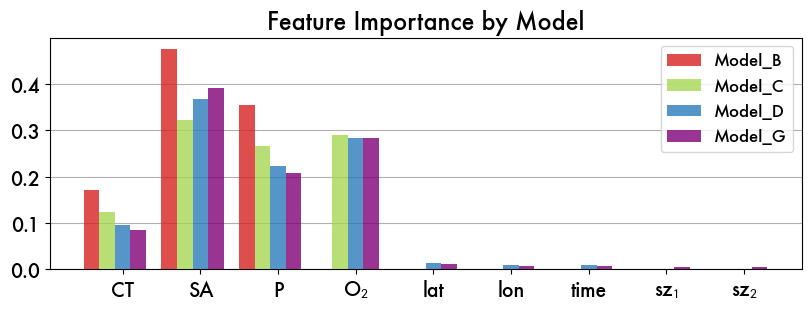

In [35]:
# Make side by side comparisons between model (grouped by variable)

fig = plt.figure(figsize=(8,3), layout='constrained')
ax = fig.gca()
barwidth=.8

# To compare models B, C, D, and G:
modlist = ['Model_B', 'Model_C', 'Model_D', 'Model_G']
varslist = ['CT', 'SA', 'pressure', 'oxygen', 'lat', 'lon', 'yearday','ydcos', 'ydsin']
xlabel = ['CT', 'SA', 'P', 'O$_2$', 'lat', 'lon', 'time', 'sz$_{1}$', 'sz$_{2}$']

# To plot the simple models A through D
# modlist = model_list[:4]
# varslist = allvars[:-4]
# xlabel = ['spice', 'sigma0', 'CT', 'SA', 'pressure', 'oxygen', 'lat', 'lon', 'yearday']

# To plot the complex models D through G
# modlist = model_list[3:]
# varslist = allvars[2:]
# xlabel = ['CT', 'SA', 'pressure', 'oxygen', 'lat', 'lon', 'yearday',
#                     'o2sat','log(N2)', 'sz1', 'sz2']

# Result of plot method
xind = dict.fromkeys(modlist)
xind[modlist[0]] = np.arange(len(varslist))*len(modlist)

for i in range(len(modlist)-1):
    xind[modlist[i+1]] = [x + barwidth for x in xind[modlist[i]]]

for modtag in modlist:
    ax.bar(xind[modtag], feat_imps[varslist].loc[modtag].to_numpy(), color = model_palettes[modtag], alpha=0.8, label = modtag, zorder=3)

ax.grid(axis='y', zorder=0)
ax.legend(loc='upper right', fontsize=12)
ax.set_xticks(xind[modlist[2]]);
ax.set_xticklabels(varslist);
ax.set_xticklabels(xlabel);
ax.set_title('Feature Importance by Model');


# PART 5: RF Validation

To select our final feature list, we screen the validation errors for each model version using the withheld validation dataset.

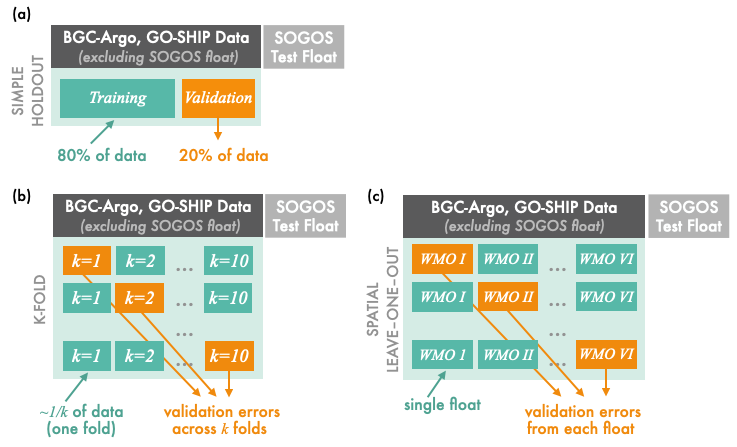

In [40]:
Image(filename='../images/crossval_schematic_small.png') 

## 5.1 "Simple" 20% Holdout Validation

- Here, we demonstrate how a typical 
- Distribution plots are errors based on the 20% validation data
- Therefore, only 20% of the data are represented here. In the next Cross-Validation step, we will use a slightly different method where all data can be represented in the validation scheme.

We plot the Gaussian kernel density estimate (KDE) for validation errors from each model A-G. The probability density is most closely centered around 0 for model G. Note similarities between models D-G, which are shown more clearly in the second figure. 

Based on the distribution of validation errors, models D, E, and G have the best performance. If two models perform similarly, the one with fewer training variables is preferred to minimize overfitting, so the final model is chosen between D and G. The difference between these two versions is that model G includes additional seasonal variables as in Sharp et al. 2022. Since the seasonal component tends to improve estimates especially near the surface, we report the following cross-validation results for model G.

- Functions for organizing errors are found in `class_RF.py`

In [41]:
# Save and print validation error metrics for a particular model
model_metrics = RF_full.get_metrics() 
model_metrics

# To save:
save=False
if save:
    model_metrics.to_csv('../working-vars/RF-training/mlresult_model_metrics_' + desc + '.csv')

In [43]:
model_metrics[['validation_MAE', 'validation_IQR', 'validation_r2']]

,validation_MAE,validation_IQR,validation_r2
ind,,,
Model_A,0.308932,0.460559,0.968101
Model_B,0.266964,0.368643,0.979110
Model_C,0.243118,0.353381,0.984171
Model_D,0.145554,0.210631,0.993101
Model_E,0.145935,0.214053,0.993127
Model_F,0.152587,0.224587,0.992676
Model_G,0.142264,0.204743,0.993179


In [44]:
# Show errors between depths
rfr.print_errors(RF_full.val_err['Model_G'], var ='val_error', pres_lim= [0,1000]); print()
# rfr.print_errors(RF_full.DF_err['Model_G'], var ='test_error', pres_lim= [0,1000])

Error metric: val_error
Restricted to depths 0 to 1000:
median abs error: 	0.14226420967661824
mean abs error 		0.20584452441725407

95% of errors fall between:
-0.58111 to 0.59002

During SOGOS between depths 0 to 1000:
95% of errors fall between:
-0.65372 to 0.63259



# PART 6: Cross Validation: K-Fold

One complication of applying RF to in-situ observations from autonomous profilers is that the training data are biased in space and time. As such, the training data are not perfectly representative of the regional dynamics and may cause overfitting during model development (Stock et al. 2022). We therefore use two other cross-validation metrics, k-fold and spatial leave-one-out, to assess the applicability of the chosen model.

In k-fold validation, the entire training dataset is split into random subsets of roughly equal size, called **folds**. We split the training data into k=10 folds, which was chosen to leave approximately 1000 point observations in each subset. Each fold is withheld as the validation set once while the model is trained on the other nine folds, such that there are 10 total iterations of the model. See Stock et al. (2022) for more details. 

## 6.1 Single K-Fold Example

In [45]:
# Split data into k=10 folds using methods 
# Exclude the SOGOS float values (reserved for Testing) 
fold_input = pd.concat([shipDF, floatDF])
fold_input = fold_input[fold_input.wmoid!=5906030]
ftrain, fvalidation = rfr.split_kfolds(fold_input, nfolds=10)

In [47]:
# EXAMPLE ONLY: One Model Run
# Demonstrating how the KFold object works. 
# In the next step, the KFold acts as an intermediate step before
# constructing the full CrossVal_KFold object. 

# Train over the k=10 folds, withholding each one for validation. 
# Set hyperparameters
kfold_mdl = 'Model_G'
nfolds = 10
description = 'ntrees=' + str(ntrees) + ', max_features=' + str(max_feats)
print('Training RF k-folds: ' + description)
print('Model: ' + kfold_mdl)

# Create the KFold object
kfold_mdlX = rfr.ModelVersion(ind_list=np.arange(1,nfolds+1))

# Run the model 
for k in tqdm(kfold_mdlX.ind_list): 
    [kfold_mdlX.models[k], kfold_mdlX.MAE[k], kfold_mdlX.IQR[k], 
     kfold_mdlX.r2[k], kfold_mdlX.DF_err[k], 
     kfold_mdlX.val_err[k]] = train_RFR(var_list[kfold_mdl], ftrain[k], fvalidation[k], test, 
                                     ntrees = ntrees, max_feats = max_feats,
                                     min_samples_split= min_samples_split)

fold_metrics = kfold_mdlX.get_metrics()
fold_metrics

Training RF k-folds: ntrees=1000, max_features=0.3333333333333333
Model: Model_G


100%|██████████| 10/10 [03:09<00:00, 18.93s/it]


,validation_MAE,validation_IQR,validation_r2,test_MAE,test_IQR,test_r2
ind,,,,,,
1,0.126824,0.184620,0.994365,0.213827,0.309720,0.985713
2,0.131729,0.187706,0.995089,0.208259,0.296752,0.986122
3,0.157800,0.227754,0.992483,0.207366,0.303762,0.986291
4,0.143180,0.193902,0.993946,0.209598,0.304956,0.985888
5,0.150824,0.216728,0.992693,0.212788,0.307661,0.985315
6,0.131227,0.196687,0.992625,0.200466,0.301123,0.986429
7,0.147720,0.223528,0.991802,0.203292,0.302633,0.986354
8,0.138026,0.178631,0.994284,0.216541,0.305796,0.986137
9,0.178575,0.249364,0.991039,0.203371,0.291318,0.986781


## 6.2 Comprehensive K-Fold Cross-Validation
- cv_kfold['Mdl_G'] is the same as KFOLD above. 

### 6.2.0 To rerun: 

In [43]:
# To re-run from existing files, if you've already run this step.:
# Warning: do not delete previous runs!

desc = 'full' # which run to retrieve
rerun = True
if rerun:
    model_list = ['Model_A', 'Model_B', 'Model_C', 'Model_D', 'Model_E', 'Model_F', 'Model_G']

    # Initialize object again
    cv_kfold = rfr.CrossVal_KFold(model_list)

    # Iteratively import the data
    for mdl in model_list: 
        df = pd.read_csv('../working-vars/RF-crossval/kfold_valDF_' + mdl + '_' + desc + '.csv')
        crossfold_MAEs = pd.read_csv('../working-vars/RF-crossval/kfold_list_MAEs_' + desc + '.csv')

        # Here's where we use the imported data 
        cv_kfold.val_DF[mdl] = df.copy()

        # Later, we will use the cv_kfold.val_error['Mdl_G'] to plot the histogram of full errors
        cv_kfold.val_error[mdl] = cv_kfold.val_DF[mdl]['val_error'] #allfold_val_df['val_error'] 
        cv_kfold.val_relative_error[mdl] = cv_kfold.val_DF[mdl]['val_relative_error']

        # We use the next imported data, MAE lists across models, 
        cv_kfold.MAEs[mdl] = crossfold_MAEs[mdl] # this is a list of 10 MAEs
                                                # mean of this is the final validation error for Model_X
        cv_kfold.IQRs[mdl] = crossfold_MAEs[mdl]


### 6.2.1 To run full k-fold validation for first time:

In [49]:
# For each model, find the validation errors for each fold
# If you want to add a model but not start over, comment out the below line:
cv_kfold = rfr.CrossVal_KFold(model_list) # By model, hold a DataFrame with the validation errors. 

for mdl in tqdm(model_list): #e.g. Model_G
    print('Running folds for ' + mdl) # which model to use for k-folding.
    
    # Here, by fold (individual KFold model for each Model_X)
    # Each KFold object then goes into the CrossVal_KFold object. 
    # Create the KFold object
    kfold_mdlX = rfr.ModelVersion(ind_list=np.arange(1,nfolds+1))

    # Run the model 
    for k in tqdm(kfold_mdlX.ind_list): 
        [kfold_mdlX.models[k], kfold_mdlX.MAE[k], kfold_mdlX.IQR[k], 
        kfold_mdlX.r2[k], kfold_mdlX.DF_err[k], 
        kfold_mdlX.val_err[k]] = train_RFR(var_list[mdl], ftrain[k], fvalidation[k], test, 
                                        ntrees = ntrees, max_feats = max_feats,
                                        min_samples_split= min_samples_split)
        
        # These are going to be all the validation errors from all folds, for histograms
        allfold_val_df = pd.DataFrame()
        for k in kfold_mdlX.ind_list:
            # Start combining all the rows from all folds
            allfold_val_df = pd.concat([allfold_val_df, kfold_mdlX.val_err[k]])
    
    # Here, by model. 
    # Fill in the full dataset, combined from all folds
    cv_kfold.val_DF[mdl] = allfold_val_df.copy()

    # Later, we will use the cv_kfold.val_error['Mdl_G'] to plot the histogram of full errors
    cv_kfold.val_error[mdl] = cv_kfold.val_DF[mdl]['val_error'] #allfold_val_df['val_error'] 
    cv_kfold.val_relative_error[mdl] = cv_kfold.val_DF[mdl]['val_relative_error']

    #These will be for  Table 1 
    fold_metrics = kfold_mdlX.get_metrics()
    cv_kfold.MAEs[mdl] = fold_metrics['validation_MAE'] # this is a list of 10 MAEs
                                                        # mean of this is the final validation error for Model_X
    cv_kfold.IQRs[mdl] = fold_metrics['validation_IQR']


# Dataframe from which we can make a boxplot of across-fold errors for each model
kfold_list_MAEs = pd.DataFrame.from_dict(cv_kfold.MAEs)


  0%|          | 0/7 [00:00<?, ?it/s]

Running folds for Model_A


 14%|█▍        | 1/7 [01:45<10:35, 105.98s/it]

Running folds for Model_B


 29%|██▊       | 2/7 [03:33<08:54, 106.84s/it]

Running folds for Model_C


 43%|████▎     | 3/7 [05:19<07:06, 106.64s/it]

Running folds for Model_D


 57%|█████▋    | 4/7 [07:45<06:06, 122.17s/it]

Running folds for Model_E


 71%|███████▏  | 5/7 [10:14<04:23, 131.78s/it]

Running folds for Model_F


 86%|████████▌ | 6/7 [12:45<02:18, 138.35s/it]

Running folds for Model_G


100%|██████████| 7/7 [15:51<00:00, 135.87s/it]


In [ ]:
# validation_error['val_error'] = Y_pred_validation - validation_nona[var_predict]
#     validation_error['val_relative_error'] = validation_error['val_error']/validation_nona[var_predict]

#     AE_RF_test = np.abs(Y_pred_test - test_nona[var_predict]) # same as DF_with_error['test_error']
#     IQR_RF_test = iqr(abs(AE_RF_test))
#     r2_RF_test = r2_score(test_nona[var_predict], Y_pred_test)

#     Mdl_MAE = [np.nanmedian(abs(AE_RF_training))

In [51]:
cvk_metrics = cv_kfold.get_metrics() # check later
cvk_metrics

# first three columns: from 10 data points (fold) 
# last three columns: from the combined dataset (all folds)

,median_MAEs,mean_MAEs,mean_IQRs,total_median_AE,total_mean_AE,total_IQR,total_median_bias
model,,,,,,,
Model_A,0.283662,0.289621,0.037706,0.288479,0.426977,0.440668,-0.051721
Model_B,0.265054,0.270904,0.017248,0.267835,0.366960,0.377585,-0.036842
Model_C,0.234984,0.243806,0.028470,0.243456,0.330017,0.344176,-0.041594
Model_D,0.145290,0.144977,0.026052,0.143196,0.205761,0.211490,-0.021140
Model_E,0.145904,0.147133,0.035950,0.146421,0.210347,0.212122,-0.018827
Model_F,0.153127,0.151306,0.026642,0.149951,0.212592,0.221497,-0.022398
Model_G,0.140603,0.143038,0.036437,0.141349,0.199901,0.204259,-0.018565


In [30]:
# Save information to run later (or import to re-run)
save=False
if save:
    cvk_metrics.to_csv('../working-vars/RF-crossval/kfold_all_metrics_' + desc + '.csv')
    kfold_list_MAEs.to_csv('../working-vars/RF-crossval/kfold_list_MAEs_' + desc + '.csv')

    for mdl in model_list:
        cv_kfold.DF[mdl].to_csv('../working-vars/RF-crossval/kfold_valDF_' + mdl + '_' + desc + '.csv')

### 6.3 Visualizing K-Fold CV Results

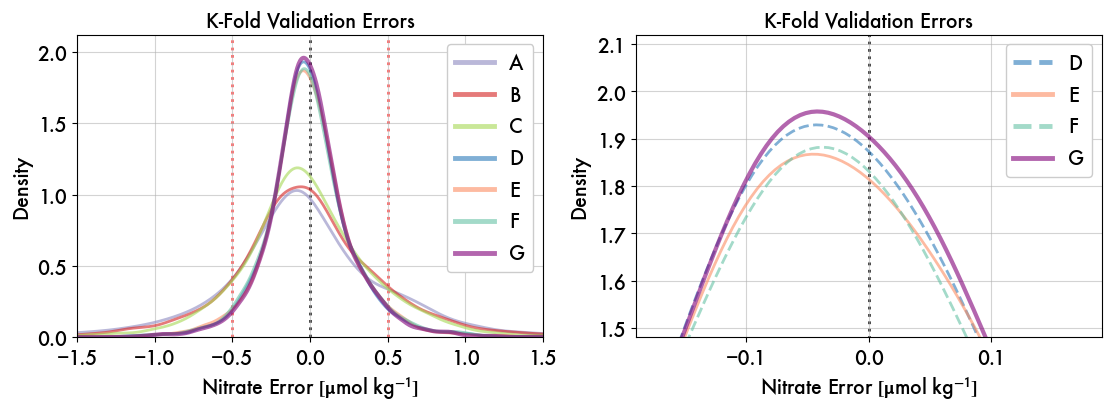

In [54]:
# Plot probability density estimate to compare model performance

reload(sgplot)
sgplot.kfold_KDE(data = cv_kfold.val_error, model_list = model_list);

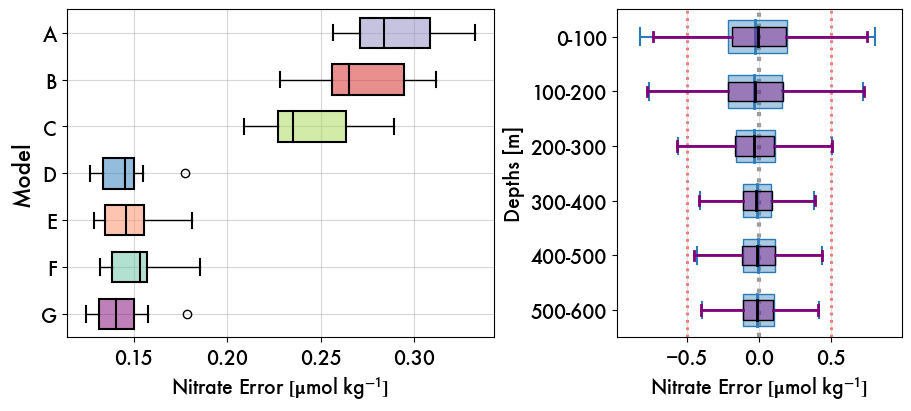

In [62]:
# Plot boxplot of MAE distributions, 
# And check error bias by depth for two models D and G

reload(sgplot)

# Plot boxplots for 10 MAEs per model
pressure_ranges = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500),
                    (500, 600) ] #(600, 700), (700, 800), (800, 900), (900, 1000)]
mod_one = 'Model_D'
mod_two = 'Model_G'
bias_one = rfr.get_depth_bias(cv_kfold.val_DF[mod_one], pressure_ranges)
bias_two = rfr.get_depth_bias(cv_kfold.val_DF[mod_two], pressure_ranges)


sgplot.kfold_boxplots(cv_kfold.MAEs, bias_one, bias_two, modlist = [mod_one, mod_two],
                      figsize = (9,4));


# PART 7: Spatial Leave-One-Out Cross-Validation

- To use this section, make sure your training/val/test data is properly defined in section 2.1.2
- Use Leave One Out holdout validation

### Make additional "holdout" datasets for spatial blocking

- The particular training_holdout['5906030'], etc. are essentially the data we will be using to develop the model by running cell block 2.1.2
- That is, we want to make the training and validation from an 80/20 split of all the data except the SOGOS 

In [67]:
# Create datasets for LOO Validation
wmos = [x for x in wmoids if x != 5906030] 
[loo_training, loo_validation] = rfr.split_loos(wmos, floatDF, shipDF)

# make holdout datasets from floats and add ship 
# keep track of #obs in each dataset
nobs_training = []; nobs_validation=[]; nobs_test=[]
for wmo in wmos:
    nobs_training.append(len(loo_training[wmo]))
    nobs_validation.append(len(loo_validation[wmo]))

dict = {'wmoid withheld': wmos, 'training obs': nobs_training, 'validation obs (withheld)': nobs_validation}
nobs_holdout = pd.DataFrame(dict)
print("# observations for spatially blocked data:"); print(nobs_holdout)

# observations for spatially blocked data:
   wmoid withheld  training obs  validation obs (withheld)
0         5904469         13537                       1041
1         5904659         12034                       2544
2         5905368         13090                       1488
3         5905996         11092                       3486
4         5906031         11322                       3256
5         5906207         12057                       2521


## 7.1 Single Model Spatial LOO

In [70]:
loomodel = 'Model_D'
ntrees = 1000
max_feats = 1/3
min_samples_split = 5
desc = 'full'
description = 'Hyperparameters: trees=' + str(ntrees) + ', max_features=' + str(max_feats)

print(description + '\n')

# Create the RF
wmos = [x for x in wmoids if x != 5906030] 
RF_loo = rfr.ModelVersion(wmos) # Let wmos be the index

for k in tqdm(wmos): 
    [RF_loo.models[k], RF_loo.MAE[k], RF_loo.IQR[k], 
     RF_loo.r2[k], RF_loo.DF_err[k], 
     RF_loo.val_err[k]] = train_RFR(var_list[loomodel], 
                            loo_training[k], loo_validation[k], test, 
                            ntrees = ntrees, max_feats = max_feats,
                            min_samples_split=min_samples_split)

loo_metrics = RF_loo.get_metrics()


Hyperparameters: trees=1000, max_features=0.3333333333333333



100%|██████████| 6/6 [01:23<00:00, 13.97s/it]


In [ ]:
# To save
save=False
if save:
    for wmo in wmos:
        # If you just ran the above, this will only give you Model G
        RF_loo.val_err[wmo].to_csv('../working-vars/RF-crossval/loo_valDF_' + loomodel + '_' + str(wmo) + '_' + desc + '.csv')

## 7.2 Comprehensive Spatial LOO across Model X's

In [36]:
# wmoids = floatDF.wmoid.unique()
# var_list = {
#             'Model_A': ['spice', 'sigma0'],
#             'Model_B': ['CT', 'SA', 'pressure'], 
#             'Model_C': ["CT", "SA", "pressure", 'oxygen'],
#             'Model_D': ["CT", "SA", "pressure", "oxygen", 'lat', 'lon', 'yearday'],
#             'Model_E': ["CT", "SA", 'pressure', 'oxygen', 'lat', 'lon', 'yearday', 'o2sat'],
#             'Model_F': ["CT", "SA", 'pressure', 'oxygen', 'lat', 'lon', 'yearday', 'log_buoyancy'],
#             'Model_G': ["CT", "SA", 'pressure', 'oxygen', 'lat', 'lon', 'yearday', 'ydcos', 'ydsin']
#             }

# model_list = list(var_list.keys())

### 7.2.0 To rerun:

In [37]:
rerun = True 
desc='full'
loomodel = 'Model_G'
wmos = [x for x in wmoids if x != 5906030] 

RF_loo = rfr.ModelVersion(wmos)
if rerun: 
    cvloo_metrics = pd.read_csv('../working-vars/RF-crossval/loo_all_metrics_' + desc + '.csv')
for wmo in wmos:
    RF_loo.val_err[wmo] = pd.read_csv('../working-vars/RF-crossval/loo_valDF_' + loomodel + '_' + str(wmo) + '_' + desc + '.csv')

cvloo = {}
for model in model_list:
    cvloo[model] = cvloo_metrics[model].values

### 7.2.1 To run LOO for the first time:

In [73]:
# To run LOO Cross Validation
ntrees = 1000
max_feats = 1/3
min_samples_split = 5
desc = 'full'
description = 'Hyperparameters: trees=' + str(ntrees) + ', max_features=' + str(max_feats)

# WARNING
# UNCOMMENT NEXT LINE, OR CVLOO WILL RESET
cvloo = {} # will become dictionary holding maes across models
wmos = [x for x in wmoids if x != 5906030] 

for loomodel in model_list: 
    RF_loo = rfr.ModelVersion(wmos) # Let wmos be the index

    for k in tqdm(wmos): 
        [RF_loo.models[k], RF_loo.MAE[k], RF_loo.IQR[k], 
        RF_loo.r2[k], RF_loo.DF_err[k], 
        RF_loo.val_err[k]] = train_RFR(var_list[loomodel], 
                                loo_training[k], loo_validation[k], test, 
                                ntrees = ntrees, max_feats = max_feats,
                                min_samples_split=min_samples_split)

    cvloo[loomodel] = RF_loo.get_metrics()['validation_MAE'].values

cvloo_metrics = pd.DataFrame.from_dict(cvloo)
cvloo_metrics['wmo'] = wmos
cvloo_metrics = cvloo_metrics.set_index('wmo')[model_list]
# cvloo_metrics[model_list]

100%|██████████| 6/6 [01:41<00:00, 16.97s/it]


In [77]:
print('Bias for each test float in SLOO.')
bias = []
for wmo in wmos: 
    bias.append(RF_loo.DF_err[wmo].test_error.mean())
bias

Bias for each test float in SLOO.


[0.063181007879857,
 0.09079014076060932,
 0.05639250744000523,
 0.13764216873452767,
 -0.23260175714064119,
 0.03603871397206139]

In [20]:
save=False
# model = 'Model_G' 
if save:
    cvloo_metrics[model_list].to_csv('../working-vars/RF-crossval/loo_all_metrics_' + desc + '.csv')
    # kfold_list_MAEs.to_csv('../working-vars/RF-crossval/kfold_list_MAEs_' + desc + '.csv')
    for wmo in wmos:
        # If you just ran the above, this will only give you Model G
        RF_loo.val_err[wmo].to_csv('../working-vars/RF-crossval/loo_valDF_' + model + '_' + str(wmo) + '_' + desc + '.csv')

## 7.3 Visualize LOO results.

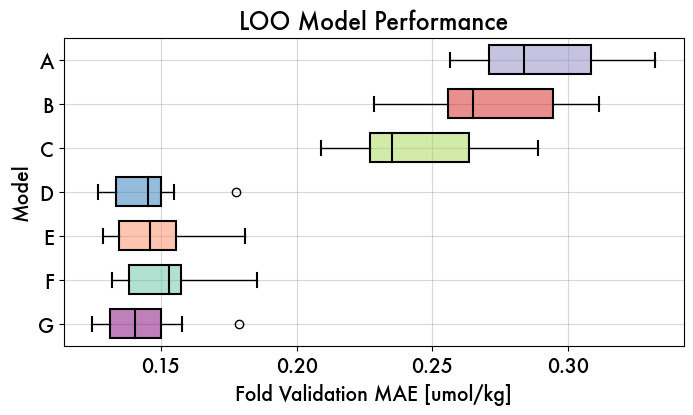

In [83]:
reload(sgplot)
ax = sgplot.loo_boxplots(cv_kfold.MAEs);
ax.set_title('LOO Model Performance');

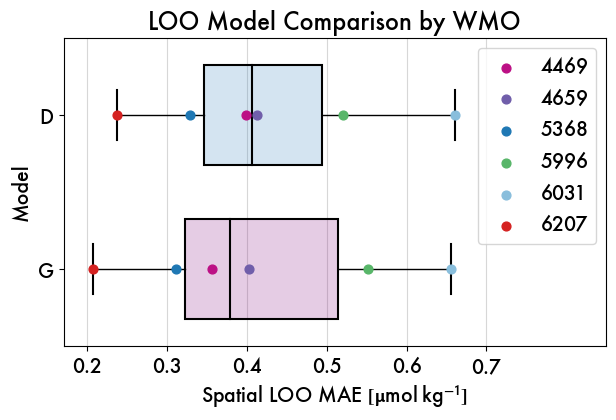

In [89]:
reload(sgplot)
ax = sgplot.loo_boxplots_wmodot(cvloo, cvloo_metrics, figsize=(8,4));
ax.set_title('LOO Model Comparison by WMO');

# PART 5: RF Test Error Analysis

## 5.0 RF Test Metric Values

In [ ]:
# Print various test error metrics
print('Absolute relative test error')
print(np.nanmean(RF_test['Model_G']['test_relative_error'])); print()

# Find bounds where 95% of the data lies
bounds = rfr.get_95_bounds(np.abs(RF_test['Model_G'].test_error))
print('95% of the data lies between: ')
print(bounds); print()

# How many observations fall within 0.5 uncertainty?
abstest = (np.abs(RF_test['Model_G'].test_error))
trues = (abstest < 0.5).value_counts()[0]
print('Percent of observations within 0.5 umol/kg error: ')
print(trues/len(abstest)*100); print()

rfr.print_errors(RF_test['Model_G'], var='test_error')


Absolute relative test error
0.002200894559102698

95% of the data lies between: 
[-0.19755135021864817, 0.7322709337252822]

Percent of observations within 0.5 umol/kg error: 
84.0689238210399

Error metric: test_error
Restricted to depths 0 to 1000:
median abs error: 	0.20341177371638605
mean abs error 		0.267359791753317

95% of errors fall between:
-0.6072 to 0.77137

During SOGOS between depths 0 to 1000:
95% of errors fall between:
-0.62364 to 1.06302


## 5.1 Plot Error Distributions (Histograms)

Text(0.5, 1.0, 'Comparison of Nitrate Distributions for SOGOS Platforms')

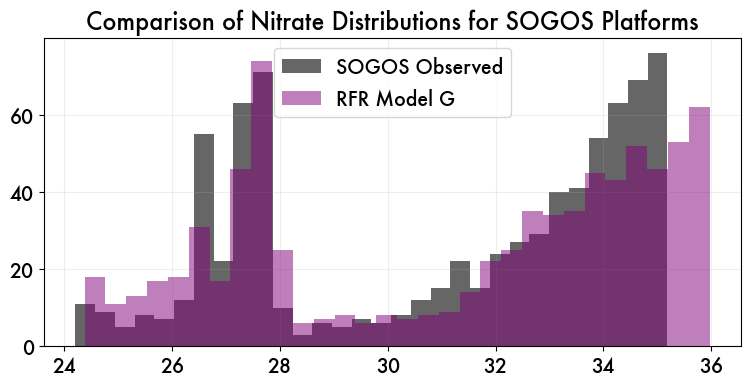

In [92]:
# Plot nitrate distributions
mod = 'Model_G'
dat = RF_full.DF_err[mod]
dat = dat[dat.yearday<200]
fig = plt.figure(figsize=(9,4))
ax = fig.gca()

ax.grid(zorder=0, alpha=0.2)
plt.hist(dat['nitrate'], bins=30, alpha=0.6, label='SOGOS Observed', color='k', zorder=1)
plt.hist(dat['test_prediction'], bins=30, alpha=0.5, label='RFR Model G', color=model_palettes[mod], zorder=3)
    
plt.legend()
ax.set_title('Comparison of Nitrate Distributions for SOGOS Platforms')

## 5.2 Time-Depth Error Sections

Text(0.5, 1.0, 'RF Nitrate Prediction')

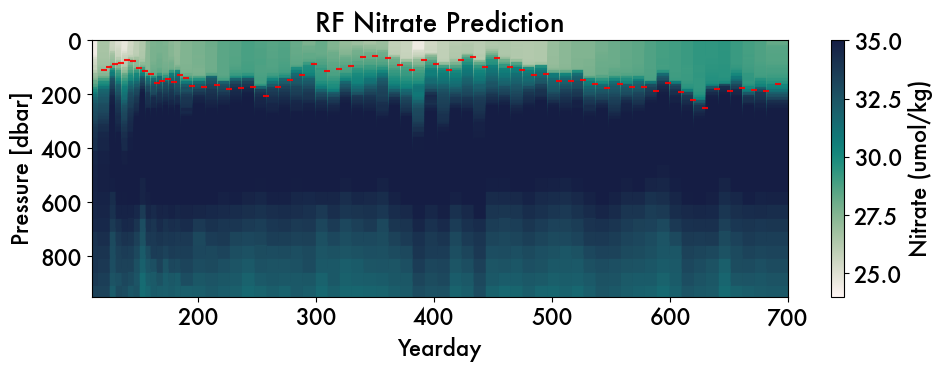

In [42]:
# Section of Model G prediction
dat = RF_test['Model_G']  # (or RF_full.DF_err)
fig  = plt.figure(figsize=(10,4), tight_layout=True)
ax = plt.gca()

sca = ax.scatter(dat.yearday, dat.pressure, c=dat.test_prediction, cmap=cmo.tempo, s=250, marker='s', vmin=24, vmax=35)
# sca = ax.scatter(dat.yearday, dat.pressure, c=dat.sigma0, cmap=cmo.tempo, s=250, marker='s')
ax.scatter(dav_6030.yearday, dav_6030.mld, c='r', s=20, marker='_', alpha=0.9, label='MLD')
plt.colorbar(sca, ax=ax).set_label('Nitrate (umol/kg)')

ax.invert_yaxis()
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')

ax.set_xlim([110,700])
ax.set_ylim([950,0])
ax.set_title('RF Nitrate Prediction')

# plt.savefig('../figures/ModelG_observation_profmap.png', dpi=300, bbox_inches='tight')

(950.0, 0.0)

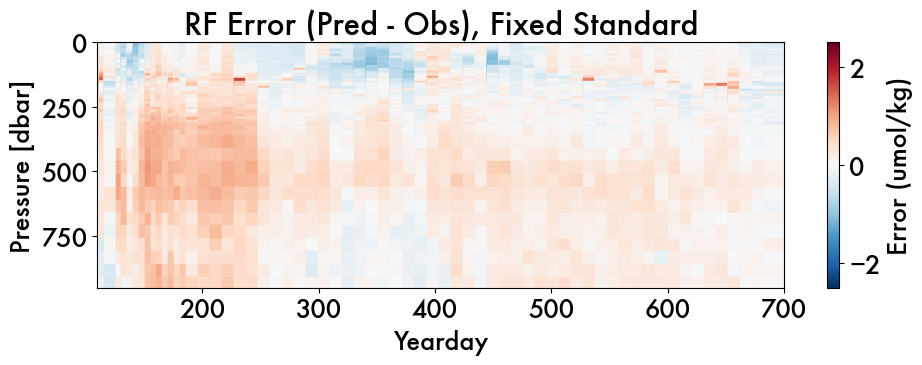

In [110]:
# SINGLE ERROR PROFILE
dat = RF_full.DF_err['Model_G']

fig  = plt.figure(figsize=(10,4), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.test_error, cmap='RdBu_r', s=250, marker='s' , vmin=-2.5, vmax=2.5)
plt.colorbar(sca, ax=ax).set_label('Error (umol/kg)')

ax.set_title('RF Error (Pred - Obs), Fixed Standard')
ax.invert_yaxis()
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')

ax.set_xlim([110,700])
ax.set_ylim([950,0])


(950.0, 0.0)

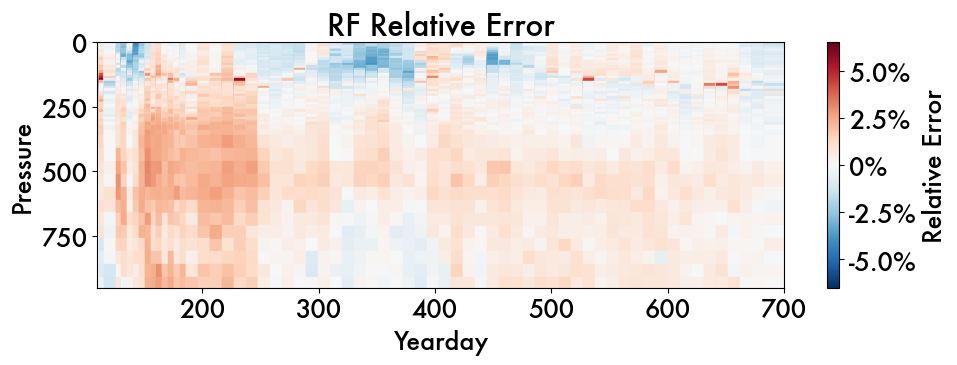

In [111]:
# SINGLE TEST RELATIVE ERROR PROFILE
dat = RF_full.DF_err['Model_G']

fig  = plt.figure(figsize=(10,4), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.test_relative_error, cmap='RdBu_r', s=250, marker='s', vmin=-.065, vmax=.065)

# ticklist = [-0.04, -0.02, 0, 0.02, 0.04] 
ticklist = [-0.05, -0.025, 0, 0.025, 0.05]
cbar = plt.colorbar(sca, ax=ax, ticks=ticklist) # [-0.28, -0.025, 0, 0.025, 0.28]
cbar.ax.set_yticklabels(['-5.0%', '-2.5%', '0%', '2.5%', '5.0%'])  # Setting tick labels here
cbar.set_label('Relative Error') 

ax.set_title('RF Relative Error')
ax.invert_yaxis()
ax.set_ylabel('Pressure')
ax.set_xlabel('Yearday')
# ax.set_xlim([120, 550])
# ax.set_ylim([600,0])

ax.set_xlim([110,700])
ax.set_ylim([950,0])


### Paper figure: Subplot Comparison Sections

Text(0.5, 0, '[Yearday]')

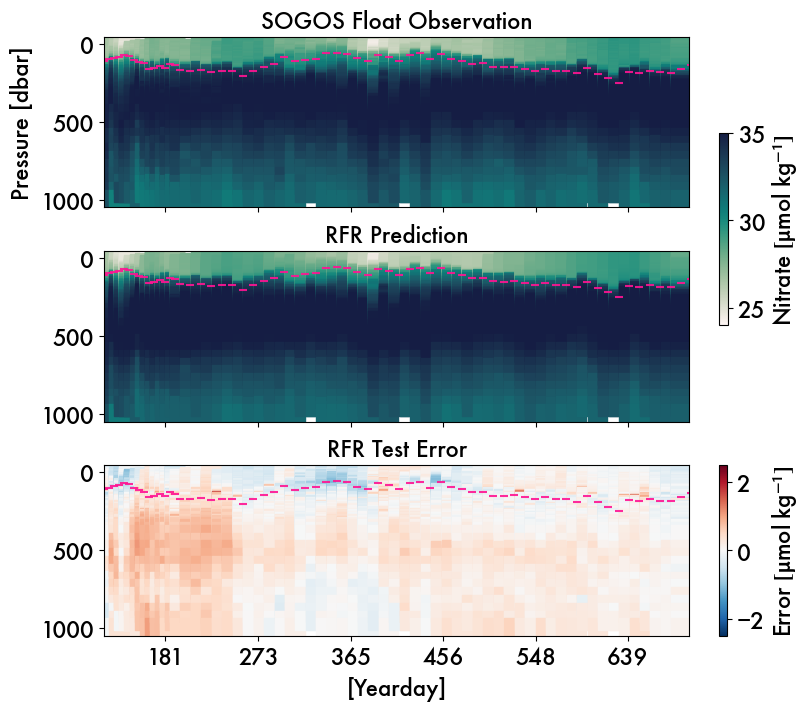

In [98]:
# * 3 Subplots: Prediction, Obs, and Error Profiles
# dat = RF_full.DF_err['Model_G']
dat = RF_test['Model_G']
tag = 'Model G'
type = 'absolute' # Choose absolute or relative errors here


fig, axs = plt.subplots(3,1, figsize=(8,7), layout='constrained', sharex=True)
axs = axs.flatten()

sca0 = axs[0].scatter(dat.yearday, dat.pressure, c=dat.nitrate, cmap=cmo.tempo, s=200, marker='s', vmin=24, vmax=35) #, vmin=0, vmax=0.005
axs[0].set_title('SOGOS Float Observation', fontsize=16) 


sca1 = axs[1].scatter(dat.yearday, dat.pressure, c=dat.test_prediction, cmap=cmo.tempo, s=200, marker='s', vmin=24, vmax=35) #, vmin=0, vmax=0.005
axs[1].set_title('RFR Prediction', fontsize=16)



fig.colorbar(sca0, ax=axs[0:2], shrink=0.5).set_label('Nitrate ' + umol_unit)

if type == 'absolute':
    sca2 = axs[2].scatter(dat.yearday, dat.pressure, c=dat.test_error, cmap='RdBu_r', s=200, marker='s', vmin=-2.5, vmax=2.5)
    axs[2].set_title('RFR Test Error', fontsize=16)
    fig.colorbar(sca2, ax=axs[2]).set_label('Error ' + umol_unit)

# elif type == 'relative':
#     sca2 = axs[2].scatter(dat.yearday, dat.pressure, c=dat.test_relative_error, cmap='RdBu_r', s=200, marker='s', vmin=-.06, vmax=.06)
#     axs[2].set_title('RFR Relative Error', fontsize=16)
#     ticklist = [-0.05, -0.025, 0, 0.025, 0.05] 
#     cbar = plt.colorbar(sca2, ax=axs[2], ticks=ticklist).set_label('Error ' + umol_unit)

for ax in axs[:]:
    ax.scatter(dav_6030.yearday, dav_6030.mld, c='deeppink', s=40, marker='_', alpha=0.9, label='MLD')

for ax in axs:
    ax.invert_yaxis()
    ax.set_xlim([120,700])

# axs[2].set_xlabel('Yearday')
axs[0].set_ylabel('Pressure [dbar]')


# xt = axs[2].get_xticks()
# axs[2].set_xticklabels(str(sg.ytd2datetime(k))[-8:] for k in xt)

xt = [181, 273, 365, 456, 548, 639]
axs[2].set_xticks(xt)
# axs[2].set_xticklabels(str(sg.ytd2datetime(k))[-5:] for k in xt)
# axs[2].set_xticklabels(['Jul \'19', 'Oct \'19','Jan \'20', 'Apr \'20', 'Jul \'20', 'Oct \'20'])

axs[2].set_xlabel('[Yearday]')

## 5.3 Plotting in T-S Space

Text(0.5, 1.0, 'Test Prediction Errors Model G')

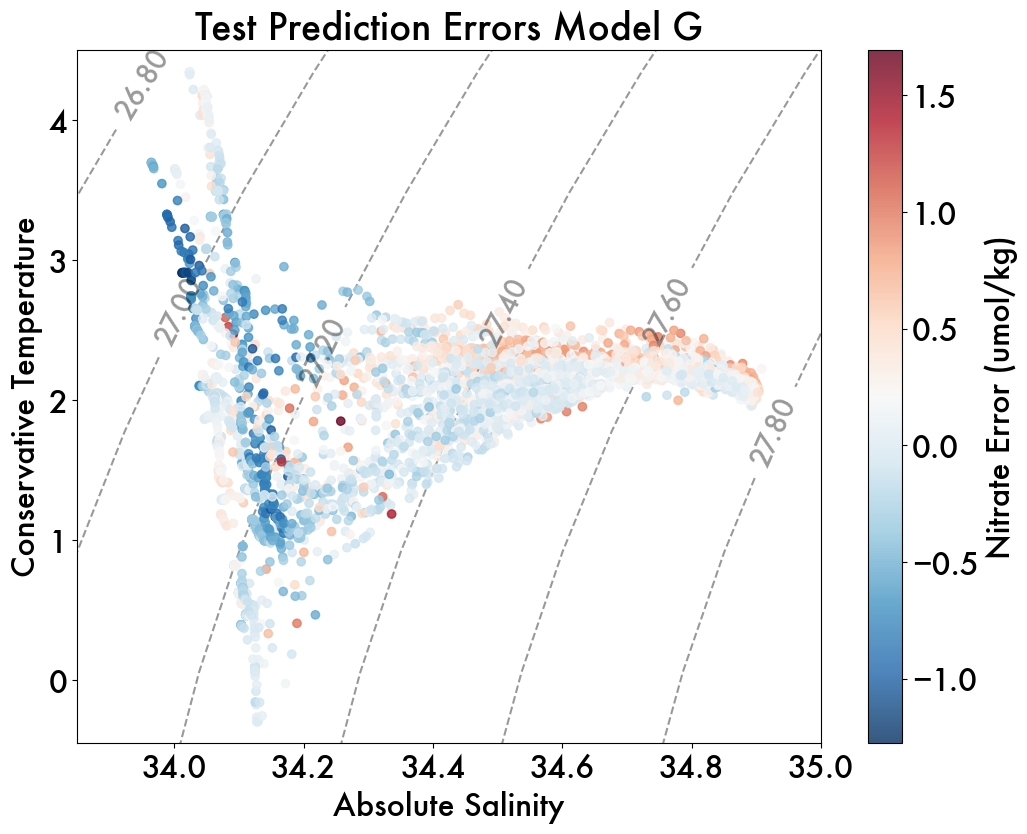

In [ ]:
# Errors in TS Space
df = RF_ver[4]['Model_G']
modtag = 'Model G'

fig = plt.figure(figsize=(12,9))
ax = fig.gca()
plt.scatter(df.SA, df.CT, c=df.test_error, cmap='RdBu_r', alpha=0.8, zorder=3)  # , vmin=-5, vmax=5
plt.colorbar().set_label('Nitrate Error (umol/kg)')
plt.show

# Add density contours
# Figure out boudaries (mins and maxs)
smin = df.SA.min() -.3
smax = df.SA.max() +.3

tmin= df.CT.min() - 1.5
tmax = df.CT.max() + 0.9

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin

# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.sigma0(si[i],ti[j])

CS = ax.contour(si,ti,dens, linestyles='dashed', colors='k', alpha=0.4, zorder=1)
ax.clabel(CS, fontsize=20, fmt='%1.2f')
ax.set_ylim(-0.45,4.5)
ax.set_xlim(33.85, 35.0)

ax.set_xlabel('Absolute Salinity')
ax.set_ylabel('Conservative Temperature')
ax.set_title('Test Prediction Errors ' + modtag)


# PART 6: Comparison to ESPER/CANYON

In [125]:
# Load datasets to compare
# sogos_float_pred = RF_test['Model_G']

# # After running CANYON and ESPER, make DataFrames
# dir = '../working-vars/'
# sogos_canyon = pd.read_csv(dir + 'CANYON-prediction/wmo5906030_MATLAB_canyon_pred_nov2023.csv')
# sogos_esper = pd.read_csv(dir + 'ESPER-prediction/wmo5906030_MATLAB_esper_pred_nov2023.csv')

# for var in ['pressure', 'yearday', 'nitrate']:
#     sogos_canyon[var] = np.array(sogos_float_pred[var])
#     sogos_esper[var] = np.array(sogos_float_pred[var])

# sogos_canyon['prediction_error'] = sogos_canyon.prediction - sogos_canyon.nitrate
# sogos_canyon['pred_relative_error'] = sogos_canyon.prediction_error/sogos_canyon.nitrate

# sogos_esper['prediction_error'] = sogos_esper.prediction - sogos_esper.nitrate
# sogos_esper['pred_relative_error'] = sogos_esper.prediction_error/sogos_esper.nitrate

In [137]:
# Load from RFR module.
from mod_RFR import RF_pred_6030, ESPER_pred, CANYON_pred


Text(0.5, 0, '[Yearday]')

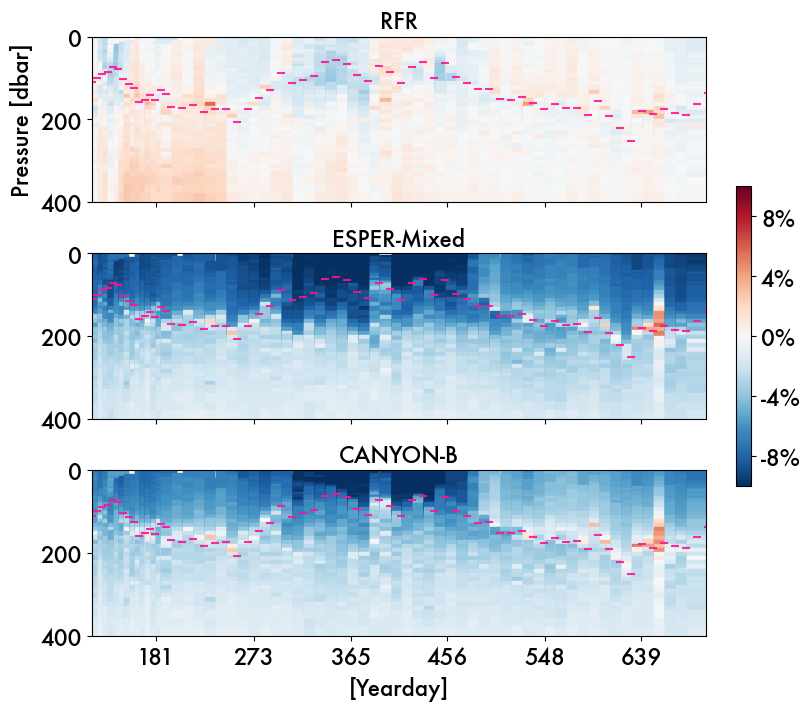

In [110]:
# * (Absolute, 3 subplots) Prediction, Obs, and Error Profiles
# RELATIVE 
dat = RF_test['Model_G']

fig, axs = plt.subplots(3,1, figsize=(8,7), layout='constrained', sharex=True)
axs = axs.flatten()

sca0 = axs[0].scatter(dat.yearday, dat.pressure, c=dat.test_relative_error, cmap='RdBu_r', s=200, marker='s', vmin=-.10, vmax=.10) #, vmin=0, vmax=0.005
axs[0].set_title('RFR', fontsize=16)

sca1 = axs[1].scatter(sogos_esper.yearday, sogos_esper.pressure, c=sogos_esper.pred_relative_error, cmap='RdBu_r', s=200, marker='s',vmin=-.10, vmax=.10) #, vmin=0, vmax=0.005
axs[1].set_title('ESPER-Mixed', fontsize=16) 

sca2 = axs[2].scatter(sogos_canyon.yearday, sogos_canyon.pressure, c=sogos_canyon.pred_relative_error, cmap='RdBu_r', s=200, marker='s', vmin=-.10, vmax=.10)
axs[2].set_title('CANYON-B', fontsize=16)

ticklist = [-0.08, -0.04, 0, 0.04, 0.08] 
cbar = fig.colorbar(sca1, ax=axs[:], ticks=ticklist, shrink=0.5).ax.set_yticklabels(['-8%', '-4%', '0%', '4%', '8%'], fontsize=16) 
# cbar.ax.set_yticklabels(['-8%', '-4%', '0%', '4%', '8%']) 

for ax in axs:
    ax.invert_yaxis()

    ax.set_xlim([120,700])
    ax.set_ylim([400,0])
    ax.scatter(dav_6030.yearday, dav_6030.mld, c='deeppink', s=40, marker='_', alpha=0.9, label='MLD')

# axs[2].set_xlabel('Days since Jan 01 2019')

axs[0].set_ylabel('Pressure [dbar]')
xt = [181, 273, 365, 456, 548, 639]
axs[2].set_xticks(xt)
# axs[2].set_xticklabels(['Jul \'19', 'Oct \'19','Jan \'20', 'Apr \'20', 'Jul \'20', 'Oct \'20'])

# axs[2].set_xticklabels(str(sg.ytd2datetime(k))[-5:] for k in xt)
axs[2].set_xlabel('[Yearday]')

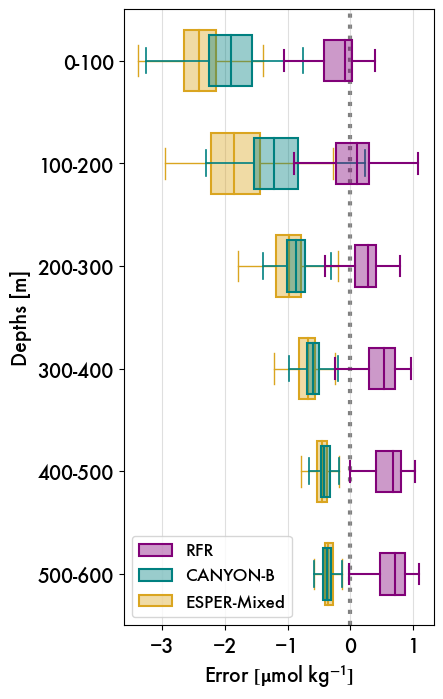

In [153]:
# Plot bias by depths, for CANYON/ESPER 
mod_one = 'RFR'
mod_two = 'CANYON-B'
mod_three = 'ESPER-Mixed'
color_one = model_palettes['Model_G'] # sns.color_palette("Purples")[3]
color_two =  'teal' #model_palettes['Model_D']
color_three = 'goldenrod'# model_palettes['Model_E']


# Get bias data over depth for CANYON, ESPER
pressure_ranges = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500),
                    (500, 600) ] #(600, 700), (700, 800), (800, 900), (900, 1000)]

bias_float = rfr.get_depth_bias(RF_pred_6030, pressure_ranges, var='test_error')
bias_canyon = rfr.get_depth_bias(CANYON_pred, pressure_ranges, var='prediction_error')
bias_esper = rfr.get_depth_bias(ESPER_pred, pressure_ranges, var='prediction_error')


# col_one = {'color':color_one, 'linewidth':1}
col_one = {'color':color_one, 'linewidth':1}
col_two = {'color':color_two, 'linewidth':1}
col_three = {'color':color_three, 'linewidth':1}

fig = plt.figure(figsize=(4,8))
# fig = plt.figure(figsize=(13,13))
ax = fig.gca()

# ESPER 
lw = 1
bplot_three = ax.boxplot(bias_esper.values(), vert=False, showfliers=False, widths=0.6, 
                    patch_artist=True, 
                    medianprops= {'color':color_three, 'linewidth':1.5},
                    capprops={'color':color_three, 'linewidth':lw},
                    whiskerprops={'color':color_three, 'linewidth':lw},
                    flierprops={'color':color_three, 'linewidth':lw},
                    boxprops = {'color':color_three, 'linewidth':1.5},
                    zorder=3)
for patch, color in zip(bplot_three['boxes'], [color_three]*10):
    patch.set_facecolor(mpcolors.to_rgba(color, alpha=0.4))

# CANYON
lw = 1.2
bplot_two = ax.boxplot(bias_canyon.values(), vert=False, showfliers=False, widths=0.5, 
                    patch_artist=True, 
                    medianprops= {'color':color_two, 'linewidth':1.5},
                    capprops={'color':color_two, 'linewidth':lw },
                    whiskerprops={'color':color_two, 'linewidth':lw },
                    flierprops={'color':color_two, 'linewidth':lw},
                    boxprops = {'color':color_two, 'linewidth':1.5},
                    zorder=4)
for patch, color in zip(bplot_two['boxes'], [color_two]*10):
    patch.set_facecolor(mpcolors.to_rgba(color, alpha=0.4))

# RFR
lw = 1.5
bplot_one = ax.boxplot(bias_float.values(), vert=False, showfliers=False, widths=0.4, 
                    patch_artist=True, 
                    medianprops= {'color':color_one, 'linewidth':lw},
                    capprops={'color':color_one, 'linewidth':lw },
                    whiskerprops={'color':color_one, 'linewidth':lw },
                    flierprops={'color':color_one, 'linewidth':lw },
                    boxprops = {'color':color_one, 'linewidth':1.5},
                    zorder=5)
for patch, color in zip(bplot_one['boxes'], [color_one]*10):
    patch.set_facecolor(mpcolors.to_rgba(color, alpha=0.4))

ax.invert_yaxis()
ax.axvline(x=0, color='k', linestyle='dotted', linewidth=3, alpha=0.5, zorder=0)

labels = bias_float.keys()
plt.yticks(range(1, len(labels) + 1), labels)
plt.ylabel("Depths [m]")
plt.xlabel("Error " + umol_unit)
# plt.title("Test Errors", fontsize=16)

ax.legend([bplot_one["boxes"][0], bplot_two["boxes"][0], bplot_three["boxes"][0]], 
          [mod_one, mod_two, mod_three], loc='lower left', fontsize=12)
ax.grid(axis='x', zorder=1, alpha=0.4)
# plt.savefig('../figures/canyon_esper_comparison_bydepth.png', dpi=300, bbox_inches='tight')

# PART 7: Final RFR Model Training


- Now, we will create one final RFR using the feature list, but this time incorporating the SOGOS float and full testing data




In [154]:
from mod_RFR import mltest as test
from mod_RFR import mlvalidation as validation
from mod_RFR import mltraining as training

In [162]:
# Train the final predictive model. 

ntrees = 1000
max_feats = 1/3
min_samples_split = 5
desc = 'full'
description = 'Hyperparameters: trees=' + str(ntrees) + ', max_features=' + str(max_feats)

print(description + '\n')

# Create the RF
RFR_Predictor = rfr.ModelVersion(ind_list = ['Model_G'])
new_training = pd.concat([training, validation, test])

for k in tqdm(['Model_G']): 
    [RFR_Predictor.models[k], RFR_Predictor.MAE[k], RFR_Predictor.IQR[k], 
     RFR_Predictor.r2[k], RFR_Predictor.DF_err[k], 
     RFR_Predictor.val_err[k]] = train_RFR(var_list[k], 
                            new_training, validation, test, # validation and test datasets don't really matter here.
                            ntrees = ntrees, max_feats = max_feats,
                            min_samples_split=min_samples_split)
    

Hyperparameters: trees=1000, max_features=0.3333333333333333



100%|██████████| 1/1 [00:28<00:00, 28.71s/it]


# PART 8: Glider Prediction

In [145]:
# df_659 = pd.read_csv('../data/glider/mldata_sg659.csv')
# df_660 = pd.read_csv('../data/glider/mldata_sg660.csv')

In [163]:
sg659 = pd.read_csv('../data/glider/sg659_tsO2corr.csv')
sg660 = pd.read_csv('../data/glider/sg660_tsO2corr.csv')

file_path = '../data/glider/'
df_659 = pd.read_csv(file_path + 'sg659_tsO2corr.csv')
df_660 = pd.read_csv(file_path + 'sg660_tsO2corr.csv')

df_659 = df_659.replace(-np.inf, np.nan)
df_659 = df_659.replace(np.inf, np.nan)

df_660 = df_660.replace(-np.inf, np.nan)
df_660 = df_660.replace(np.inf, np.nan)

df_659 = add_yd_sinusoids(df_659)
df_660 = add_yd_sinusoids(df_660)


In [165]:
len(sg.list_profile_DFs(df_660))

1004

In [166]:
# Method predict glider
def predict_glider(glidDF, Mdl, var_list, var_predict='nitrate'):
    X_glid= glidDF[var_list].to_numpy()
    Y_glid = Mdl.predict(X_glid)
    return Y_glid

df_659['nitrate_G'] = predict_glider(df_659, RFR_Predictor.models['Model_G'], var_list['Model_G'])
df_660['nitrate_G'] = predict_glider(df_660, RFR_Predictor.models['Model_G'], var_list['Model_G'])

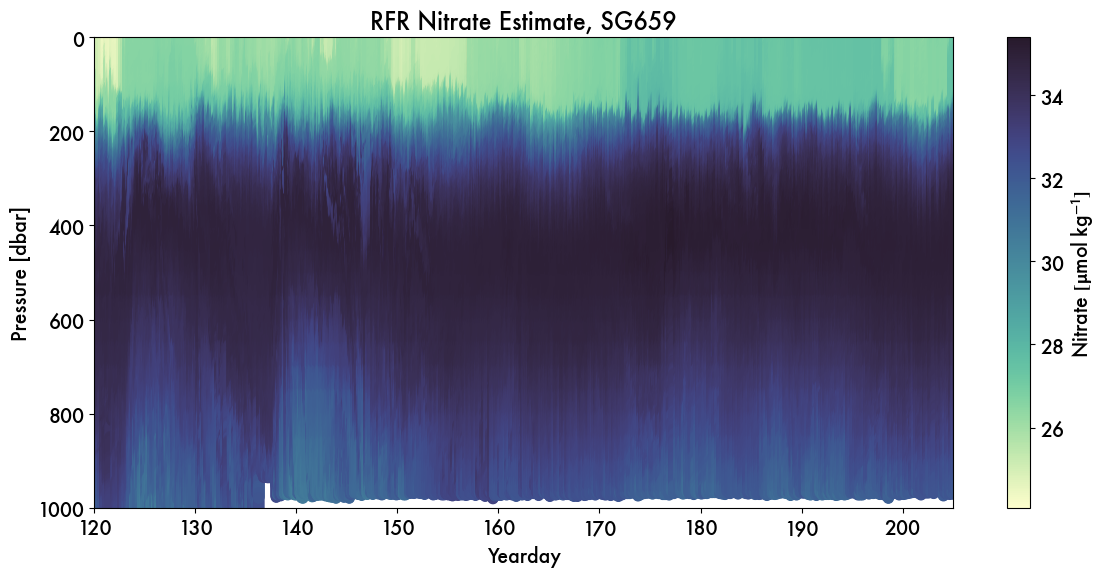

In [167]:
# * Glider prediction nitrate profile

# dat = df_659[(df_659.yearday <maxday) & (df_659.yearday > minday)]
dat = df_659
tag = 'RFR Nitrate Estimate, SG659'


fig  = plt.figure(figsize=(10,5), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.nitrate_G, cmap=cmo.deep, s=50) #, vmin=1.5, vmax=3.6) #, marker='s')
ax.set_title(tag )

plt.colorbar(sca, ax=ax).set_label('Nitrate ' + umol_unit)

ax.invert_yaxis()
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')
ax.set_xlim([120, 205])
ax.set_ylim([1000,0])

plt.show()


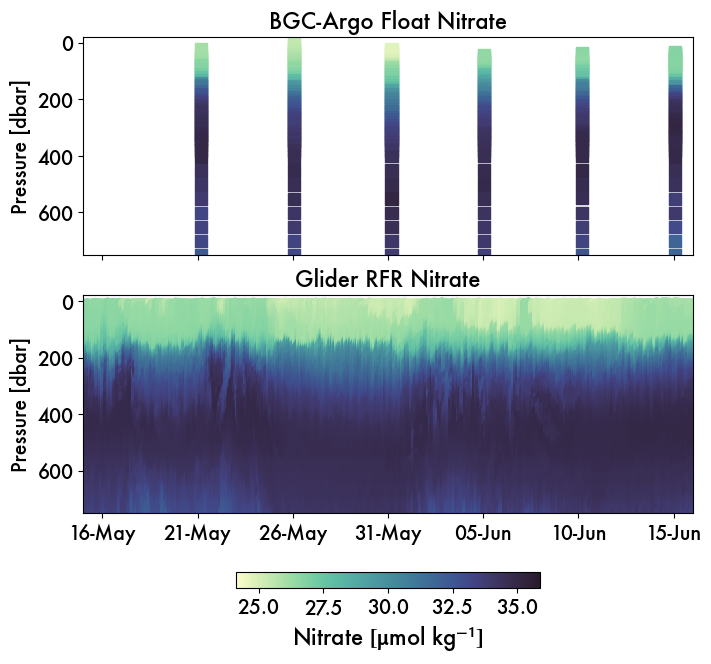

In [168]:
importlib.reload(sgplot)
# sgplot.compare_resolution(df_660, fsize=(9,6), minday=129, maxday=161, maxpres=750, dateformat=False)
sgplot.compare_resolution(df_660, fsize=(7,6.5), minday=129, maxday=161, maxpres=750, dateformat=True, vertical=False)

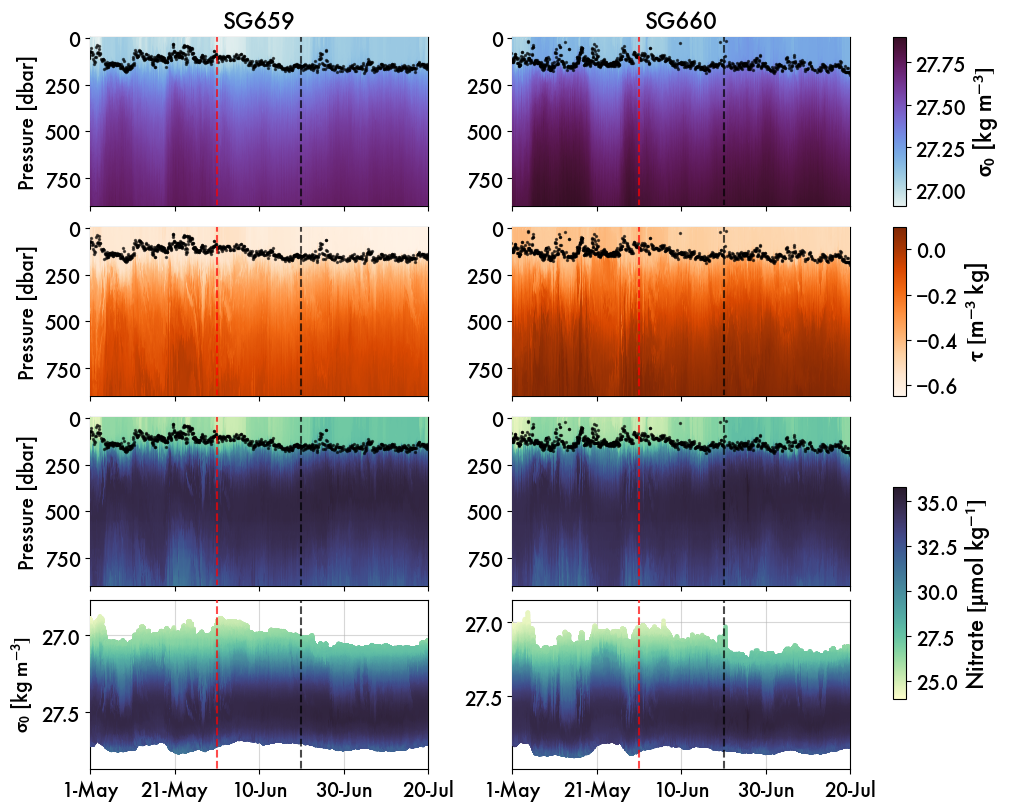

In [171]:
reload(sgplot)
sgplot.plt_glider_sections(preslim=900, fsize=(10,8), font = 14, dateformat=True);

In [31]:
# # file_path = '../working-vars/nitrate-prediction/'
# df_659.to_csv('../working-vars/RF-glider/mlpred_sg659_G.csv')
# df_660.to_csv('../working-vars/RF-glider/mlpred_sg660_G.csv')

# END